# Проект 8 Прогнозирование стоимости автомобиля

### Цель проекта:
Создать максимально точную модель, предсказывающую стоимость автомобиля по доступной информации (в том числе фотографии и текстовое описание). Данная модель позволит покупателям получать оценку адекватности предлагаемой продавцом цены.

### Для достижения поставленной цели видится необходимым решение следующих задач:  

<a href='#1'>1. Подготовка среды (загрзука данных, библиотек, блок с функциями).

<a href='#2'>2. Разведывательный анализ и Feature Engineering.

<a href='#3'>3. Классический ML-modeling. Анализ результатов.

<a href='#4'>4. Решение задачи с помощью FNN (MLP).  

<a href='#5'>5. NLP + DL.

<a href='#6'>6. Добавляем CV.  
    
<a href='#7'>7. Анализ лучших результатов     

<a id='1'></a>  
### Подготовка среды

In [80]:
import random
import numpy as np 
import pandas as pd
import os
import sys
import PIL
import cv2
import re
import torch
import pymorphy2
import tqdm
from collections import Counter
import optuna
from optuna import trial


from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from nltk.corpus import stopwords
from utils import FeatureSelector, make_automl_prediction,\
                                   make_catboost_prediction,\
                                   preproc_for_classic_ml,\
                                   make_lgbm_prediction,\
                                   preproc_for_mlp

import matplotlib.pyplot as plt
import seaborn as sns
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


#Настройки pandas
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 200

In [2]:
# Фиксируем случайность для воспроизводимости:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [3]:
#Наша основная метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
#Загружаем данные:
train = pd.read_csv('data_storage/Batmobile/train.csv')
test = pd.read_csv('data_storage/Batmobile/test.csv')

#Каталог с картинками по ссылке:
#https://drive.google.com/drive/folders/10Jz2EpDpkRlYKo25ZrJ1l7sILFrvDXo7?usp=sharing

Видим, что есть обучающий корпус данных и данные для submission

<a id='2'></a> 
## Разведывательный анализ и Feature Engineering

In [5]:
# Смотрим как выглядят данные:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,"Авто на бодром ходу. Все работает отлично. По электрике,ходовой.,АКПП ДВС нареканий нет.., Масло не ест. .!!!Салон ухожен. На запчасти денег не жалел. Жидкости все поменял. Крашена одна дверь ...",3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС оригинал.\nОтличное состояние, вложений не требует.\nКомплект новой зимней резины Nokian.\nПо кузову мелкие притертости. В базе бьется как 2 ДТП, т.к....",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобили с пробегом мы предлагаем специальную кредитную программу «Гарантия минимального ежемесячного платежа».\nУсловия кредитования:\n• Первоначальный взно...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,"В комплекте зимние колёса. 27.07.2020 Замена передних тормозных дисков, Замена масла в двигателе и коробке со всеми фильтрами, Замена свечей зажигания. Машина в хорошем состояние. Возможен торг. П...",2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме переднего левого крыла весь в родной краске.\nФактически 2 физических владельца, одна запись это автосалон, в который первый хозяин сдал машину в трейд-инн,...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [8]:
#Приведем все столбцы к латинице и нижнему регистру:
dict_col_names = {'Владельцы': 'Owners', 'Привод': 'transmission', 'Владение': 'Ownership', 'ПТС': 'Tech_passport', 'Руль': 'Wheel'}
for data in [train, test]:
    data.rename(dict_col_names, axis=1, inplace=True)
    data.columns = data.columns.str.lower()

In [9]:
#Проверим датасет на наличие дубликатов:
print('Дубликаты есть' if any(train.duplicated()) else 'Дубликатов нет')

Дубликатов нет


In [10]:
# Проверим какое максимальное количество пропусков в строке:
Count_rows = train.isnull().sum(axis=1).value_counts()
percent_nans=round(pd.Series(Count_rows.index/train.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(train.isnull().sum(axis=1))/train.shape[1]
print('Максимум незаполненных строк в датафрейме:', round(misses*100, 2), "%")
pd.DataFrame({'Количество случаев строке': Count_rows, 
              'Количество пропусков в строке': Count_rows.index,
              'Процент незаполненных значений в строке': percent_nans}).sort_values('Количество пропусков в строке', ascending=False).reset_index().drop('index',axis=1)

Максимум незаполненных строк в датафрейме: 4.55 %


,Количество случаев строке,Количество пропусков в строке,Процент незаполненных значений в строке
0,2355,1,5.0 %
1,4327,0,0.0 %


In [11]:
# Считаем процент пропусков
train.isnull().sum()[train.isnull().sum()>0]

owners          1
ownership    4326
dtype: int64

В тренировочном датасете практически нет пропусков. Только в поле Владение.

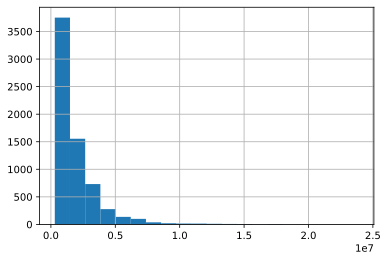

In [12]:
# Посмотрим как распределена целевая переменная:
train.price.hist(bins=20);

Видим, что распределение скошено вправо. Следовательно, можно попробовать "выправить" путем логарифмирования, можно попробовать удалить экстремально высокие цены. Посмотреть, как повлияет на качество.

Так как признаков немного, проанализируем каждый из них.

In [13]:
#Объединим train и test для единного препроцессинга:
train['sample'] = 'train' # помечаем где у нас трейн
test['sample'] = 'test' # помечаем где у нас тест
test['price'] = np.nan 
data = pd.concat([train, test], axis=0)

#### BodyType

In [14]:
data.bodytype.unique() #Видим, что количество категорий можно уменьшить, убрав информацию о кол-ве дверей.

array(['седан', 'лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.',
       'минивэн', 'универсал 5 дв.', 'купе-хардтоп', 'купе', 'кабриолет',
       'родстер', 'хэтчбек 3 дв.', 'компактвэн', 'пикап двойная кабина',
       'внедорожник открытый', 'седан 2 дв.', 'внедорожник 3 дв.',
       'лимузин'], dtype=object)

In [15]:
data['bodytype'] = data.bodytype.map(lambda x: x.split()[0].strip())

#### Brand

In [16]:
data.brand.unique()

array(['BMW', 'AUDI', 'MERCEDES'], dtype=object)

In [17]:
data.brand.value_counts() # распределение более менее равномерное

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

#### Color

In [18]:
data.color.unique()

array(['чёрный', 'серебристый', 'белый', 'синий', 'серый', 'красный',
       'коричневый', 'зелёный', 'голубой', 'пурпурный', 'бежевый',
       'фиолетовый', 'оранжевый', 'золотистый', 'жёлтый', 'розовый'],
      dtype=object)

In [19]:
data.color.value_counts() #есть редкие цвета

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

### Description

Поле текстовое, будет обрабатываться отдельно для Catboost, отдельно для NLP DL.

#### EngineDisplacement

In [20]:
data.enginedisplacement.unique() # Видим, что это числовая переменная закодированная как текст. Нужно поправить.

array(['3.0 LTR', '2.8 LTR', '3.5 LTR', '2.0 LTR', '1.8 LTR', '5.5 LTR',
       '2.5 LTR', '1.6 LTR', '1.5 LTR', '4.8 LTR', '4.4 LTR', '3.8 LTR',
       '2.2 LTR', '4.0 LTR', '2.1 LTR', '2.4 LTR', '4.7 LTR', '1.2 LTR',
       '3.6 LTR', '3.1 LTR', '0.7 LTR', '6.0 LTR', '4.1 LTR', '5.0 LTR',
       '5.4 LTR', '6.2 LTR', '4.2 LTR', '1.4 LTR', '2.9 LTR', '1.7 LTR',
       '3.2 LTR', '2.7 LTR', '1.9 LTR', '1.3 LTR', '5.2 LTR', '3.7 LTR',
       '5.9 LTR', '4.9 LTR', '2.3 LTR', '6.6 LTR', '3.4 LTR', '6.3 LTR',
       '2.6 LTR', 'undefined LTR', '5.6 LTR', '4.3 LTR', '4.6 LTR',
       '5.8 LTR'], dtype=object)

In [21]:
data[data.enginedisplacement=='undefined LTR'].fueltype.unique() # Видим, что данное значение присутствует только у электрокаров

array(['электро'], dtype=object)

In [22]:
#Корректируем значения
data['enginedisplacement'] = data.enginedisplacement.map(lambda x: float(x.split()[0]) if x!='undefined LTR' else np.nan)

#### EnginePower

In [23]:
data.enginepower.unique()[:20] # Признак числовой, закодированный как текст. Нужно поправить.

array(['272 N12', '204 N12', '306 N12', '180 N12', '160 N12', '184 N12',
       '197 N12', '326 N12', '190 N12', '245 N12', '224 N12', '585 N12',
       '211 N12', '225 N12', '218 N12', '156 N12', '231 N12', '238 N12',
       '140 N12', '150 N12'], dtype=object)

In [24]:
data['enginepower'] = data.enginepower.map(lambda x: int(x.split()[0]))

#### FuelType

In [25]:
data.fueltype.value_counts() # очень мало гибриных и электро каров

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fueltype, dtype: int64

#### Mileage

In [26]:
data.mileage.nunique() #Признак числовой с большим количеством вариаций

3507

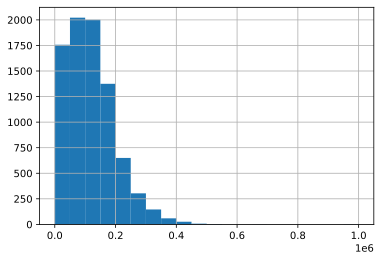

In [27]:
data.mileage.hist(bins=20); # есть длинный хвост

#### ModelDate и ProductionDate

In [28]:
data[['modeldate', 'productiondate']].corr() # Признаки почти всегда совпадают

,modeldate,productiondate
modeldate,1.000000,0.964919
productiondate,0.964919,1.000000


С точки зрения ценнобразования, кажется, что более важна дата производства, нежели год появления модели.

In [29]:
#Удаляем избыточный столбец
data.drop('modeldate', axis=1, inplace=True)

In [30]:
data.productiondate.unique() #Выглядит нормально

array([2007, 2011, 2013, 2020, 2016, 2015, 2014, 2017, 2008, 2009, 2006,
       2012, 2018, 2005, 1985, 1992, 2019, 2004, 2010, 2002, 2001, 2003,
       1994, 2000, 1999, 1997, 1990, 1995, 1986, 1993, 1988, 1996, 1998,
       1987, 1982, 1983, 1984, 1989, 1991], dtype=int64)

In [31]:
# Сделаем признак возраст авто, как разность от отчетного года (2021 го):
data['auto_age'] = 2021-data.productiondate
data.drop('productiondate', axis=1, inplace=True)

#### Model_info & name   

In [32]:
data.model_info.unique()

array(['5ER', 'A6', 'E_KLASSE', 'A5', 'C_KLASSE', '7ER', '3ER', 'X4',
       'M_KLASSE', 'S_KLASSE_AMG', 'Q5', 'CLA_KLASSE', 'GLA_CLASS', 'X1',
       'Q7', 'X2', 'X5', 'B_KLASSE', 'X6_M', 'S_KLASSE', 'VITO', 'A3',
       '1ER', 'CLS_KLASSE', 'X6', 'S_CLASS_MAYBACH', 'CL_KLASSE',
       'G_KLASSE_AMG', 'GLC_KLASSE', 'GLS_KLASSE', 'A8', 'A4',
       'GLE_KLASSE_COUPE_AMG', 'X3', 'Q3', 'X7', 'G_KLASSE',
       'GLS_KLASSE_AMG', 'I3', 'VIANO', 'GL_KLASSE', 'V_KLASSE',
       'SLK_KLASSE', 'GLC_COUPE', 'CLS_KLASSE_AMG', 'A_KLASSE', 'S7', '4',
       'A7', '6ER', 'RS6', 'M_KLASSE_AMG', 'GLK_KLASSE', 'R_KLASSE',
       'GLE_KLASSE', 'Z4', 'A1', 'C_KLASSE_AMG', 'GLE_KLASSE_AMG',
       'GLC_KLASSE_AMG', 'Z3', 'CLK_KLASSE', 'X5_M', 'M6', 'ALLROAD',
       'SLS_AMG', 'S5', '2GRANDTOURER', 'SL_KLASSE', 'E_KLASSE_AMG',
       'W124', 'GLE_KLASSE_COUPE', 'SLC_KLASSE', 'TT', 'S8',
       'CLA_KLASSE_AMG', 'R8', 'M5', '2ER', 'RSQ3', 'S4', 'CL_KLASSE_AMG',
       'Q8', 'AMG_GT', 'GLA_CLASS_AMG', 'M4'

In [33]:
#Есть значение None, замеменим на S63, исходя из описания:
data.model_info.replace('None', 'S63', inplace=True)
#Есть маркеры премиум пакета (M, AMG):
data['is_premium_package'] = data.model_info.map(lambda x: 1 if ('AMG' in x) or ('_M' in x) or (x.startswith('M')) else 0)
data['is_drive_package'] = data.name.map(lambda x: 1 if 'drive' in x.lower() else 0)


In [34]:
#Проверяем, что все преимум пакеты исчезли:
data[data.is_premium_package==0].name.unique()[:20]

array(['530xi 3.0 AT (272 л.с.) 4WD', '2.8 CVT (204 л.с.)',
       '350 3.5 AT (306 л.с.) 4WD', '2.0 CVT (180 л.с.)',
       '1.8 CVT (160 л.с.)', '200 1.8 AT (184 л.с.)',
       '200 2.0 AT (197 л.с.) 4WD', '740Li xDrive 3.0 AT (326 л.с.) 4WD',
       '1.8 AMT (190 л.с.)', '320d xDrive 2.0d AT (184 л.с.) 4WD',
       '28i 2.0 AT (245 л.с.) 4WD', '2.0 AMT (211 л.с.) 4WD',
       '2.0 AMT (225 л.с.) 4WD', '525i 2.5 AT (218 л.с.)',
       '528i 2.0 AT (245 л.с.)', '200 1.6 AMT (156 л.с.)',
       '250 2.0 AMT (211 л.с.) 4WD', '3.0d AMT (245 л.с.) 4WD',
       '730d 3.0d AT (231 л.с.)', '20i 2.0 AT (184 л.с.) 4WD'],
      dtype=object)

#### Numberofdoors

In [36]:
data.numberofdoors.unique() #Здесь нужно слепить 2-3 и 4-5, так как это одно и тоже (считался багажник как дверь или нет)
data.numberofdoors = data.numberofdoors.map(lambda x: 'Две' if x in (2,3) else 'Четыре')

In [37]:
data.numberofdoors.value_counts() #Все логично

Четыре    7490
Две        863
Name: numberofdoors, dtype: int64

#### VehicleConfiguration & Vehicletransmission

In [38]:
data.vehicletransmission.unique()

array(['автоматическая', 'вариатор', 'роботизированная', 'механическая'],
      dtype=object)

In [39]:
data.vehicletransmission.value_counts() #в датасете довольно мало МКП, в остальном все ок

автоматическая      6560
роботизированная    1201
вариатор             406
механическая         186
Name: vehicletransmission, dtype: int64

Поле VehicleConfiguration дублирует информацию из других столбцов

#### Owners & Ownership

In [40]:
#Что у нас тут:
data.owners.value_counts(dropna=False)

3 или более    3311
1 владелец     2526
2 владельца    2515
NaN               1
Name: owners, dtype: int64

In [41]:
# Видим, что значения с битой кодировкой:
data.owners.unique()

array(['3 или более', '2\xa0владельца', '1\xa0владелец', nan],
      dtype=object)

In [42]:
d = {'3 или более':'3+', '2\xa0владельца': '2', '1\xa0владелец': '1'}
data.owners = data.owners.map(d)

In [43]:
# Теперь ОК:
data.owners.unique()

array(['3+', '2', '1', nan], dtype=object)

In [44]:
# Видим, что машине 20 лет, поэтому заполним пропуск как 3 и более:
data.owners = data.owners.fillna('3+')

In [45]:
#Лучше заменить на количество месяцев
data.ownership.unique()[:10]

array([nan, '8 лет и 6 месяцев', '4 года и 9 месяцев',
       '2 года и 9 месяцев', '6 лет и 9 месяцев', '4 года и 3 месяца',
       '5 лет и 7 месяцев', '1 год и 2 месяца', '3 года',
       '4 года и 10 месяцев'], dtype=object)

In [46]:
def num_of_months(x):
    ''' Функция считает время владения машиной в месяцах'''
    
    if pd.notnull(x):
        list_ownership = x.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])

data.ownership = data.ownership.map(num_of_months)

In [47]:
#Проверяем
data.ownership.unique()[:10]

array([ nan, 102.,  57.,  33.,  81.,  51.,  67.,  14.,  36.,  58.])

In [48]:
#Видим, что есть пропуски во владении, когда один владелец. Можно заполнить.
data[data.ownership.isna()].owners.value_counts()

3+    2171
1     1649
2     1598
Name: owners, dtype: int64

In [49]:
#Заполняем
data.loc[(data.ownership.isna())&(data.owners=='1'), 'ownership'] = data.loc[(data.ownership.isna())&(data.owners=='1'), 'auto_age']*12

In [50]:
# Проверяем
data[data.ownership.isna()].owners.value_counts()

3+    2171
2     1598
Name: owners, dtype: int64

#### Tech_passport

In [51]:
data.tech_passport.value_counts() #здесь все ок

Оригинал    7474
Дубликат     879
Name: tech_passport, dtype: int64

#### Transmission

In [52]:
data.transmission.value_counts() #здесь все ок

полный      5218
задний      2259
передний     876
Name: transmission, dtype: int64

#### Wheel

In [53]:
data.wheel.value_counts() # очень низкая кардинальность признака.

Левый     8351
Правый       2
Name: wheel, dtype: int64

In [54]:
# Удаляем
data.drop('wheel', axis=1, inplace=True)

#### Description

Предобработаем текстовое поле, но также и сохраним исходный вариант. Он может понадобится для его обработки с помощью трансформеров, e.g. BERT.  
  
Основными этапами будут являться:  
- понижение регистра;  
- удаление пунктуации и лишних символов;  
- удаление стоп-слов;  
- лемматизация.

In [55]:
# Загрузим стандартный набор стоп-слов
russian_stopwords = stopwords.words("russian")

In [56]:
from catboost.text_processing import Tokenizer

simple_tokenizer = Tokenizer(lowercasing=True,
                             number_process_policy='Skip',
                             separator_type='BySense',
                             token_types=['Word'])

In [57]:
data['text_feature'] = data.description.map(lambda x: ' '.join([word for word in simple_tokenizer.tokenize(x) if word not in russian_stopwords]))

In [58]:
#Лемматизация
morphy = pymorphy2.MorphAnalyzer()
data['text_feature'] = data.text_feature.map(lambda x: ' '.join([morphy.normal_forms(word)[0] for word in x.split()]))

In [59]:
#Посмотрим на топ 10 самых популярных слов
c = Counter()
for word in tqdm.tqdm(' '.join(list(set(data.text_feature.values.flatten().tolist()))).split()):
    c[word]+=1
c.most_common(10)

100%|██████████| 608260/608260 [00:00<00:00, 1145006.25it/s]


[('автомобиль', 12616),
 ('система', 8848),
 ('задний', 6156),
 ('сидение', 5753),
 ('салон', 5752),
 ('состояние', 4781),
 ('передний', 4699),
 ('пробег', 4500),
 ('машина', 4478),
 ('год', 4102)]

На этом предварительная обработка текста заканчивается

In [60]:
# Добавим еще несколько признаков в датасет:
data['miles_per_year'] = data['mileage'] // (data['auto_age'])

In [61]:
# Эксперименты с целевой переменной
data.price = np.log(data.price)
#data.price = np.exp(data.price)

In [62]:
# Распредляем признаки по типам:
cat_cols = ['bodytype', 'brand', 'color', 'fueltype', 'model_info', 'numberofdoors', 'vehicletransmission', 'owners', 'tech_passport', 'transmission']
num_cols = ['enginedisplacement', 'enginepower', 'mileage', 'miles_per_year']

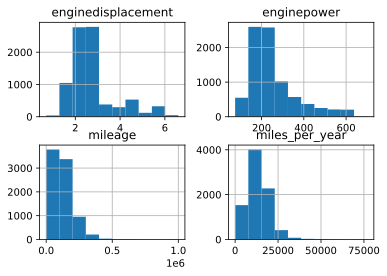

In [63]:
data[num_cols].hist();

<a id='3'></a>  
### Классический ML-modeling. Анализ результатов.

In [64]:
# Разделим данные на обратно train/test:
train_data = data.query('sample == "train"').drop(['sample'], axis=1)
test_data = data.query('sample == "test"').drop(['sample'], axis=1)

In [65]:
#Baseline -- Прогноз по модели авто и году выпуска:

df = train_data.groupby(['model_info', 'auto_age']).price.median()
submit = pd.concat([test_data[['sell_id']], test_data[['model_info', 'auto_age', 'price']].set_index(['model_info', 'auto_age']).price.fillna(df).reset_index()], axis=1)
submit['price'] = submit.set_index('model_info').price.fillna(train_data.groupby("model_info").price.median()).reset_index().price
submit['price'] = submit.set_index('auto_age').price.fillna(train_data.groupby("auto_age").price.median()).reset_index().price
submit['price'] = (submit.price//1000)*1000
submit.drop(['model_info', 'auto_age'], axis=1, inplace=True)
submit.to_csv('baseline_submission.csv', index=False)


Результат  baseline на лидерборде по MAPE - 18.76

In [66]:
#CatBoost modeling:

params = {
    'iterations': 2000,
    'learning_rate': 0.2,
    'random_seed': RANDOM_STATE,
    'depth':6,
    'eval_metric': 'MAPE',
    'task_type':'GPU',
    'loss_function':'MAPE'
}

train_data = data.query('sample == "train"').drop(['sample'], axis=1)
test_data = data.query('sample == "test"').drop(['sample'], axis=1)

train, valid = train_test_split(train_data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)



cb_preds, model = make_catboost_prediction(estimator=CatBoostRegressor(**params),
                             train=train,
                             valid=valid,
                             test=None,
                             cat_features=cat_cols,
                             return_model=True,
                             target_name='price',
                             cols_to_drop = ['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'])


0:	learn: 0.0415269	test: 0.0421920	best: 0.0421920 (0)	total: 35.9ms	remaining: 1m 11s
250:	learn: 0.0094268	test: 0.0095804	best: 0.0095804 (250)	total: 8.25s	remaining: 57.5s
500:	learn: 0.0083478	test: 0.0091465	best: 0.0091398 (497)	total: 17.1s	remaining: 51.2s
750:	learn: 0.0076032	test: 0.0089557	best: 0.0089535 (746)	total: 26.4s	remaining: 43.9s
1000:	learn: 0.0070617	test: 0.0088664	best: 0.0088602 (935)	total: 36.6s	remaining: 36.5s
1250:	learn: 0.0066000	test: 0.0088017	best: 0.0088005 (1249)	total: 47s	remaining: 28.1s
1500:	learn: 0.0062133	test: 0.0087580	best: 0.0087457 (1443)	total: 56.3s	remaining: 18.7s
1750:	learn: 0.0059119	test: 0.0087265	best: 0.0087249 (1742)	total: 1m 6s	remaining: 9.4s
1999:	learn: 0.0056336	test: 0.0087076	best: 0.0086990 (1948)	total: 1m 15s	remaining: 0us
bestTest = 0.008699039068
bestIteration = 1948
Shrink model to first 1949 iterations.


In [67]:
print(f"TEST mape: {(mape(np.exp(valid.price), cb_preds))*100:0.2f}%")

TEST mape: 12.31%


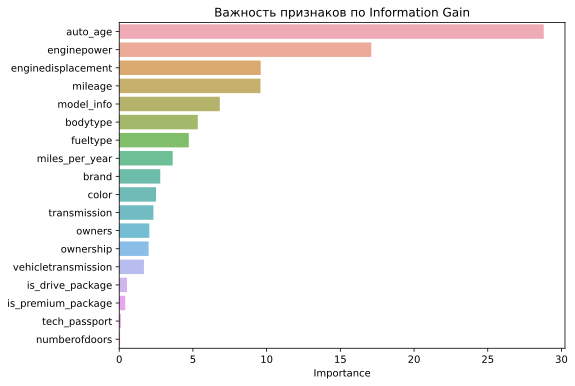

In [68]:
#Посмотрим на важность признаков
FI = pd.DataFrame(zip(model.feature_names_, model.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
# Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize = (8, 6))
bar_plot = sns.barplot(x='Importance', y='Feature', data=FI, alpha=0.8, ci=None)
plt.title('Важность признаков по Information Gain')
plt.ylabel('')
plt.show()

In [69]:
#submit 
test_data.price = make_catboost_prediction(estimator=model,
                             train=train,
                             valid=valid,
                             test=test_data,
                             cat_features=cat_cols,
                             return_model=False,
                             target_name='price',
                             cols_to_drop = ['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'])
test_data[['sell_id', 'price']].to_csv('catboost_submission.csv', index=False)

13.25 на private leaderboard

#### Проверим automl

In [70]:
param_dict = {
    'RANDOM_STATE': RANDOM_STATE,
    'N_THREADS': 6,
    'TIMEOUT': 1200,
    'N_FOLDS': 5
}

#Make predicition
automl_preds = make_automl_prediction(train=data.query('sample == "train"').drop(['sample'], axis=1),
                           test=data.query('sample == "test"').drop(['sample'], axis=1),
                           cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration'],
                           task_type='reg',
                           loss='mape',
                           target_name='price',
                           **param_dict
)

test_data.price = automl_preds

test_data[['sell_id', 'price']].to_csv('automl_submission.csv', index=False)


12.29 MAPE на public leaderboard

#### Проверим AdaBoost, RandomForest, ExtraTrees

In [78]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

data_classic = preproc_for_classic_ml(data, cat_cols, ['description', 'name', 'vehicleconfiguration', 'text_feature'])

data_train = data_classic.query('sample == "train"').drop(['sample'], axis=1)
data_test = data_classic.query('sample == "test"').drop(['sample'], axis=1)

train_, valid_ = train_test_split(data_train.drop('sell_id', axis=1), test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

rf = RandomForestRegressor(n_estimators=2000, random_state=RANDOM_STATE)
rf.fit(X=train_.drop('price', axis=1), y=train_.price)
rf_preds = (np.exp(rf.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape RF: {(mape(np.exp(valid_.price), rf_preds))*100:0.2f}%")

ada_boost = AdaBoostRegressor(n_estimators=1000, learning_rate=0.2, base_estimator=DecisionTreeRegressor(max_depth=12), random_state=RANDOM_STATE)
ada_boost.fit(X=train_.drop('price', axis=1), y=train_.price)
ada_preds = (np.exp(ada_boost.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape AdaBoost: {(mape(np.exp(valid_.price), ada_preds))*100:0.2f}%")

extra = ExtraTreesRegressor(n_estimators=2000, n_jobs=-1, random_state=RANDOM_STATE)
extra.fit(X=train_.drop('price', axis=1), y=train_.price)
extra_preds = (np.exp(extra.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape Extra: {(mape(np.exp(valid_.price), extra_preds))*100:0.2f}%")

preds = (extra_preds+cb_preds)/2
print(f"TEST mape Extra+CB: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

TEST mape RF: 13.38%
TEST mape AdaBoost: 13.46%
TEST mape Extra: 13.15%
TEST mape Extra+CB: 12.18%


12.60 MAPE on public leaderboard

#### Можно ли повысить качество с помощью отбора признаков?

In [79]:
params = {
    'iterations': 2000,
    'learning_rate': 0.2,
    'random_seed': RANDOM_STATE,
    'depth':6,
    'eval_metric': 'MAPE',
    'task_type':'GPU',
    'loss_function':'MAPE'
}


In [83]:
f_sel = FeatureSelector(estimator = CatBoostRegressor(**params),
                        train_data = train.reset_index(drop=True),
                        val_data=valid.reset_index(drop=True),
                        target_col='price',
                        cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                        cat_features=cat_cols)

In [84]:
best_f = f_sel.drop_useless_cols().get_best_features(bigger_is_better=False, n_iter=6)

Удалено признаков с нулевой значимостью: 0
Осталось признаков: 18


100%|██████████| 6/6 [05:58<00:00, 59.78s/it]

Baseline: 5 features and 0.0092 score
----------------------------------------
iteration: 1 of 6| added: ['bodytype', 'fueltype'] | new set of features: 7 of 20 | new score: 0.0087
iteration: 4 of 6| added: ['owners', 'ownership'] | new set of features: 9 of 22 | new score: 0.0087
iteration: 6 of 6| added: ['is_premium_package', 'tech_passport'] | new set of features: 11 of 24 | new score: 0.0087
----------------------------------------
final set of features: 11, -54.1% reduction of initial set | new score: 0.0087, -5.8% improvement vs initial


In [116]:
#Запишем отобранные признаки
with open('best_feature.txt', 'w') as f:
    for feature in best_f:
        f.write(str(feature)+'\n')

In [75]:
best_f = pd.read_csv('best_feature.txt', header=None).values.flatten().tolist()

In [77]:
params = {
    'iterations': 3000,
    'learning_rate': 0.25,
    'random_seed': RANDOM_STATE,
    'eval_metric': 'MAPE',
    'task_type':'GPU',
    'loss_function':'MAPE'
}


cb_preds, cb_reg = make_catboost_prediction(estimator=CatBoostRegressor(**params),
                                    train=train[best_f+['price']],
                                    valid=valid[best_f+['price']],
                                    test=None,
                                    cat_features=cat_cols,
                                    return_model=True,
                                    target_name='price',
                                    cols_to_drop = [])



0:	learn: 0.0413589	test: 0.0420158	best: 0.0420158 (0)	total: 106ms	remaining: 5m 17s
250:	learn: 0.0092543	test: 0.0095218	best: 0.0095218 (250)	total: 8.4s	remaining: 1m 32s
500:	learn: 0.0082718	test: 0.0091645	best: 0.0091626 (486)	total: 16.5s	remaining: 1m 22s
750:	learn: 0.0075382	test: 0.0089074	best: 0.0089058 (748)	total: 25.1s	remaining: 1m 15s
1000:	learn: 0.0070598	test: 0.0088012	best: 0.0087990 (997)	total: 34.2s	remaining: 1m 8s
1250:	learn: 0.0066570	test: 0.0087318	best: 0.0087315 (1245)	total: 43.4s	remaining: 1m
1500:	learn: 0.0063332	test: 0.0086803	best: 0.0086720 (1452)	total: 51.9s	remaining: 51.8s
1750:	learn: 0.0060824	test: 0.0086472	best: 0.0086464 (1747)	total: 1m	remaining: 43s
2000:	learn: 0.0058762	test: 0.0086635	best: 0.0086357 (1817)	total: 1m 8s	remaining: 34.2s
2250:	learn: 0.0056525	test: 0.0086253	best: 0.0086246 (2248)	total: 1m 16s	remaining: 25.5s
2500:	learn: 0.0054730	test: 0.0086502	best: 0.0086216 (2258)	total: 1m 24s	remaining: 16.9s
2750

In [90]:
print(f"TEST mape: {(mape(np.exp(valid.price), cb_preds))*100:0.2f}%")

TEST mape: 12.26%


In [81]:
# Попробуем classic ML на новом наборе фичей:
data_classic = preproc_for_classic_ml(data[best_f+['sample','price']], cat_cols)

data_train = data_classic.query('sample == "train"').drop(['sample'], axis=1)
data_test = data_classic.query('sample == "test"').drop(['sample'], axis=1)

train_, valid_ = train_test_split(data_train, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

rf = RandomForestRegressor(n_estimators=2000, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X=train_.drop('price', axis=1), y=train_.price)
rf_preds = (np.exp(rf.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape RF: {(mape(np.exp(valid_.price), rf_preds))*100:0.2f}%")

ada_boost = AdaBoostRegressor(n_estimators=1000, learning_rate=0.2, base_estimator=DecisionTreeRegressor(max_depth=12), random_state=RANDOM_STATE)
ada_boost.fit(X=train_.drop('price', axis=1), y=train_.price)
ada_preds = (np.exp(ada_boost.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape AdaBoost: {(mape(np.exp(valid_.price), ada_preds))*100:0.2f}%")

extra = ExtraTreesRegressor(n_estimators=2000, n_jobs=-1, random_state=RANDOM_STATE)
extra.fit(X=train_.drop('price', axis=1), y=train_.price)
extra_preds = (np.exp(extra.predict(valid_.drop('price', axis=1)))//1000)*1000
print(f"TEST mape Extra: {(mape(np.exp(valid_.price), extra_preds))*100:0.2f}%")

#Пробуем усреднить:
preds = (rf_preds+ada_preds+extra_preds)/3
print()
print(f"TEST mape RF+Ada+Extra: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

#Пробуем усреднить с катбуст:
preds = (extra_preds+cb_preds)/2
print(f"TEST mape CB+Extra: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

#Пробуем усреднить с adaboost с катбуст:
preds = (ada_preds+cb_preds)/2
print(f"TEST mape CB+Ada: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

#Пробуем усреднить все:
preds = (ada_preds+cb_preds+extra_preds+rf_preds)/4
print(f"TEST mape all: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

#Пробуем усреднить все:
preds = (cb_preds+rf_preds)/2
print(f"TEST mape CB+RF: {(mape(np.exp(valid_.price), preds))*100:0.2f}%")

TEST mape RF: 13.24%
TEST mape AdaBoost: 13.06%
TEST mape Extra: 13.34%

TEST mape RF+Ada+Extra: 12.84%
TEST mape CB+Extra: 12.10%
TEST mape CB+Ada: 12.01%
TEST mape all: 12.28%
TEST mape CB+RF: 12.18%


In [115]:
#Final submit

cb_preds = make_catboost_prediction(estimator=cb_reg,
                             train=train,
                             valid=valid,
                             test=test_data[best_f+['price']],
                             cat_features=cat_cols,
                             return_model=False,
                             target_name='price',
                             cols_to_drop = [])

ada_boost = AdaBoostRegressor(n_estimators=1000, learning_rate=0.2, base_estimator=DecisionTreeRegressor(max_depth=12), random_state=RANDOM_STATE)
ada_boost.fit(X=data_train.drop('price', axis=1), y=data_train.price)
ada_preds = (np.exp(ada_boost.predict(data_test.drop('price', axis=1)))//1000)*1000

test_data['price'] = (((automl_preds+cb_preds+ada_preds)/3)//1000)*1000

test_data[['sell_id', 'price']].to_csv('bland_submission.csv', index=False)

12.13 MAPE on public leaderboard

#### Протестим perfomance LGBM

In [72]:
cat_cols = ['bodytype', 'brand', 'color', 'fueltype', 'model_info', 'numberofdoors', 'vehicletransmission', 'owners', 'tech_passport', 'transmission']

df = data.copy()

for column in cat_cols:
    df[column] = df[column].astype('category').cat.codes


train_data = df.query('sample == "train"').drop(['sample'], axis=1)
test_data = df.query('sample == "test"').drop(['sample'], axis=1)



train, valid = train_test_split(train_data, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)


In [65]:
lgbm_params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'mape'
}

lgbm_preds, lgbm_model = make_lgbm_prediction(estimator=LGBMRegressor(**lgbm_params),
                                  train=train,
                                  valid=valid,
                                  test=None,
                                  cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                  return_model=True,
                                  cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                  target_name='price',
                                  is_fitted=False)

Training until validation scores don't improve for 500 rounds
[250]	train's mape: 0.0107161	valid's mape: 0.0112269
[500]	train's mape: 0.00775132	valid's mape: 0.00887875
[750]	train's mape: 0.00704049	valid's mape: 0.00855176
[1000]	train's mape: 0.00667219	valid's mape: 0.00848554
[1250]	train's mape: 0.00640068	valid's mape: 0.00845004
[1500]	train's mape: 0.00620527	valid's mape: 0.00843117
[1750]	train's mape: 0.0060458	valid's mape: 0.00841592
[2000]	train's mape: 0.00590466	valid's mape: 0.00840557
[2250]	train's mape: 0.00577248	valid's mape: 0.00839823
[2500]	train's mape: 0.00566675	valid's mape: 0.00839281
[2750]	train's mape: 0.00555511	valid's mape: 0.00838732
[3000]	train's mape: 0.00545936	valid's mape: 0.00838481
[3250]	train's mape: 0.00539181	valid's mape: 0.00838416
[3500]	train's mape: 0.00532069	valid's mape: 0.00838324
[3750]	train's mape: 0.00524652	valid's mape: 0.00837977
[4000]	train's mape: 0.00518557	valid's mape: 0.00838162
[4250]	train's mape: 0.00513001	

In [66]:
print(f"TEST mape all: {(mape(np.exp(valid.price), lgbm_preds))*100:0.2f}%")

TEST mape all: 11.65%


In [167]:
test_data['price'] = make_lgbm_prediction(estimator=lgbm_model,
                                  train=train,
                                  valid=valid,
                                  test=test_data,
                                  cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                  return_model=False,
                                  cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                  target_name='price',
                                  is_fitted=True)

test_data[['sell_id', 'price']].to_csv('lgbm_submission.csv', index=False)

MAPE 11.91 on public leaderboard

#### Попробуем отобрать признаки с помощью LGBM

In [86]:
f_sel = FeatureSelector(estimator = LGBMRegressor(**lgbm_params),
                        train_data = train.reset_index(drop=True),
                        val_data=valid.reset_index(drop=True),
                        target_col='price',
                        cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                        cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')])

In [87]:
best_f = f_sel.drop_useless_cols().get_best_features(bigger_is_better=False, n_iter=6)

Удалено признаков с нулевой значимостью: 0
Осталось признаков: 18


100%|██████████| 6/6 [01:01<00:00, 10.23s/it]

Baseline: 5 features and 0.0098 score
----------------------------------------
iteration: 1 of 6| added: ['auto_age', 'enginedisplacement'] | new set of features: 7 of 20 | new score: 0.0088
iteration: 2 of 6| added: ['color', 'owners'] | new set of features: 9 of 22 | new score: 0.0087
iteration: 3 of 6| added: ['transmission', 'brand'] | new set of features: 11 of 24 | new score: 0.0087
iteration: 4 of 6| added: ['fueltype', 'bodytype'] | new set of features: 13 of 26 | new score: 0.0083
iteration: 4 of 6| removed: miles_per_year | new set of features: 12 of 25 | new score: 0.0082
----------------------------------------
final set of features: 12, -52.0% reduction of initial set | new score: 0.0082, -16.% improvement vs initial


In [89]:
#Запишем отобранные признаки
with open('best_feature_lgbm.txt', 'w') as f:
    for feature in best_f:
        f.write(str(feature)+'\n')

In [98]:
lgbm_params = {
    'n_estimators': 6000,
    'learning_rate': 0.01,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'mape'
}


lgbm_preds, lgbm_reg = make_lgbm_prediction(estimator=LGBMRegressor(**lgbm_params),
                                        train=train[best_f+['price']],
                                        valid=valid[best_f+['price']],
                                        test=None,
                                        cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                        return_model=True,
                                        target_name='price',
                                        cols_to_drop = [])


Training until validation scores don't improve for 500 rounds
[250]	train's mape: 0.0107257	valid's mape: 0.011235
[500]	train's mape: 0.00786701	valid's mape: 0.00889068
[750]	train's mape: 0.00719241	valid's mape: 0.0085833
[1000]	train's mape: 0.00681873	valid's mape: 0.00846632
[1250]	train's mape: 0.00655634	valid's mape: 0.00840721
[1500]	train's mape: 0.00633751	valid's mape: 0.00837645
[1750]	train's mape: 0.00617656	valid's mape: 0.00835187
[2000]	train's mape: 0.00604316	valid's mape: 0.00833856
[2250]	train's mape: 0.00592604	valid's mape: 0.00832407
[2500]	train's mape: 0.0058192	valid's mape: 0.00830999
[2750]	train's mape: 0.00574104	valid's mape: 0.00829978
[3000]	train's mape: 0.00564995	valid's mape: 0.00829552
[3250]	train's mape: 0.00557147	valid's mape: 0.00829038
[3500]	train's mape: 0.00550445	valid's mape: 0.00828396
[3750]	train's mape: 0.00543862	valid's mape: 0.00827858
[4000]	train's mape: 0.00536656	valid's mape: 0.00827442
[4250]	train's mape: 0.00531501	va

In [99]:
print(f"TEST mape all: {(mape(np.exp(valid.price), lgbm_preds))*100:0.2f}%")

TEST mape all: 11.50%


In [101]:
test_data['price'] = make_lgbm_prediction(estimator=lgbm_reg,
                                  train=train,
                                  valid=valid,
                                  test=test_data[best_f+['price']],
                                  cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                  return_model=False,
                                  cols_to_drop=[],
                                  target_name='price',
                                  is_fitted=True)

test_data[['sell_id', 'price']].to_csv('lgbm_sel_f_submission.csv', index=False)

#### Попробуем потюнить модель

In [144]:
train_val = pd.concat([train, valid])

def objective(trial):

    param = {

        "objective": "mape",
        "n_jobs": -1,
        "random_state": RANDOM_STATE,
        "verbosity": -1,
        'learning_rate': 0.01,
        'n_estimators': 5000,
        "reg_alpha": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 256),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "subsample": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_depth": trial.suggest_int("max_depth", 6, 15)
    }

   
    # cv scoring with given parameters:

    kf = KFold(n_splits=5)
    mape_cv = 0
    for train_index, test_index in kf.split(train_val):
        tr, val = train_val[train_index], train_val[test_index]
        preds = make_lgbm_prediction(estimator=LGBMRegressor(**param),
                                        train=tr,
                                        valid=val,
                                        test=None,
                                        cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                        return_model=False,
                                        target_name='price',
                                        cols_to_drop = ['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                        verbose=False,
                                        early_stopping_rounds=500)

        mape_ = mape(np.exp(val.price), preds)
        mape_cv+=mape_

    return mape_cv/5
 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 200
Best trial:
  Value: 0.11306112680948621
  Params: 
    lambda_l1: 0.0012111135659419042
    lambda_l2: 2.2243049905155353e-06
    num_leaves: 16
    feature_fraction: 0.7830314165546455
    bagging_fraction: 0.8650825781656136
    bagging_freq: 4
    min_child_samples: 29


In [73]:
lgbm_params = {
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'objective': 'mape',
    'lambda_l1': 0.0012111135659419042,
    'lambda_l2': 2.2243049905155353e-06,
    'num_leaves': 16,
    'feature_fraction': 0.7830314165546455,
    'bagging_fraction': 0.8650825781656136,
    'bagging_freq': 4,
    'min_child_samples': 29
}

lgbm_preds, lgbm_model = make_lgbm_prediction(estimator=LGBMRegressor(**lgbm_params),
                                  train=train,
                                  valid=valid,
                                  test=None,
                                  cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                  return_model=True,
                                  cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                  target_name='price',
                                  is_fitted=False,
                                  verbose=500,
                                  early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[500]	train's mape: 0.00864343	valid's mape: 0.00905275
[1000]	train's mape: 0.00760786	valid's mape: 0.00850151
[1500]	train's mape: 0.00715365	valid's mape: 0.0083767
[2000]	train's mape: 0.00683823	valid's mape: 0.00830849
[2500]	train's mape: 0.00659872	valid's mape: 0.00826058
[3000]	train's mape: 0.00640881	valid's mape: 0.00823972
[3500]	train's mape: 0.00625145	valid's mape: 0.00822029
[4000]	train's mape: 0.0061191	valid's mape: 0.00820799
[4500]	train's mape: 0.00600817	valid's mape: 0.00820104
[5000]	train's mape: 0.00591199	valid's mape: 0.00819325
[5500]	train's mape: 0.00582845	valid's mape: 0.00818844
[6000]	train's mape: 0.00575233	valid's mape: 0.0081828
[6500]	train's mape: 0.0056824	valid's mape: 0.00818167
[7000]	train's mape: 0.00562086	valid's mape: 0.00817924
[7500]	train's mape: 0.00556626	valid's mape: 0.00817356
[8000]	train's mape: 0.00551452	valid's mape: 0.00817259
Early stopping, best iteration 

In [74]:
print(f"TEST mape all: {(mape(np.exp(valid.price), lgbm_preds))*100:0.2f}%")

TEST mape all: 11.35%


In [321]:
test_data['price'] = make_lgbm_prediction(estimator=lgbm_model,
                                  train=train,
                                  valid=valid,
                                  test=test_data,
                                  cat_features=[col for col in cat_cols if col not in ('tech_passport', 'numberofdoors')],
                                  return_model=False,
                                  cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                  target_name='price',
                                  is_fitted=True)

test_data[['sell_id', 'price']].to_csv('lgbm_tune_submission.csv', index=False)

11.79 MAPE on public leaderboard

In [322]:
previous_preds = pd.read_csv('bland_submission.csv') # ADA+LAMA+CB
test_data['price'] = (previous_preds.price+test_data['price'])/2 # усредняем
test_data[['sell_id', 'price']].to_csv('lgbm_bland_submission.csv', index=False) # делаем submit

11.71 MAPE on public leaderboard

<a id='4'></a>  
### Решение задачи с помощью FNN (MLP).

In [64]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

In [65]:
data.price = np.exp(data.price)

In [66]:
train, valid, test = preproc_for_mlp(data,
                                     cat_cols=cat_cols,
                                     cols_to_drop=['description', 'name', 'sell_id', 'vehicleconfiguration', 'text_feature'],
                                     scaler=StandardScaler,
                                     target='price',
                                     random_state=RANDOM_STATE)

#Пробуем убрать низкие и высокие таргеты из обучающей выборки (не сработало)
# q_01 = train.price.quantile(0.01)
# q_99 = train.price.quantile(0.99)

# train = train[train.price.between(q_01,q_99)]

train_X, train_y = train.drop('price', axis=1).values, train.price.values
valid_X, valid_y = valid.drop('price', axis=1).values, valid.price.values
test_X, test_y = test.drop('price', axis=1).values, test.price.values

In [89]:
#Восстанавливаем состояние рандома
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


## Simple Dense NN
model = Sequential()
model.add(L.Dense(64, input_dim=train_X.shape[1], activation="elu"))
model.add(L.Dense(64, activation="selu"))
model.add(L.Dense(1, activation="linear"))
# Compile model

optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
checkpoint = ModelCheckpoint('MLP_storage/best_model2.hdf5' , monitor=['val_MAPE'], verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=50, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]
### Fit
history = model.fit(train_X, train_y,
                    batch_size=256, # изменение batch_size в большую и меньшую сторону также не дает улучшения
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(valid_X, valid_y),
                    callbacks=callbacks_list,
                    verbose=1,
                   )


Epoch 1/1000
21/21 [==============================] - 1s 50ms/step - loss: 99.9959 - MAPE: 99.9959 - val_loss: 99.9843 - val_MAPE: 99.9843 - lr: 0.0100
Epoch 2/1000
21/21 [==============================] - 0s 8ms/step - loss: 99.9412 - MAPE: 99.9412 - val_loss: 99.8535 - val_MAPE: 99.8535 - lr: 0.0100
Epoch 3/1000
21/21 [==============================] - 0s 10ms/step - loss: 99.6706 - MAPE: 99.6706 - val_loss: 99.3517 - val_MAPE: 99.3517 - lr: 0.0100
Epoch 4/1000
21/21 [==============================] - 0s 9ms/step - loss: 98.8637 - MAPE: 98.8637 - val_loss: 98.0747 - val_MAPE: 98.0747 - lr: 0.0100
Epoch 5/1000
21/21 [==============================] - 0s 9ms/step - loss: 97.0782 - MAPE: 97.0782 - val_loss: 95.5209 - val_MAPE: 95.5209 - lr: 0.0100
Epoch 6/1000
21/21 [==============================] - 0s 9ms/step - loss: 93.8257 - MAPE: 93.8257 - val_loss: 91.1450 - val_MAPE: 91.1450 - lr: 0.0100
Epoch 7/1000
21/21 [==============================] - 0s 15ms/step - loss: 88.5335 - MAPE: 8

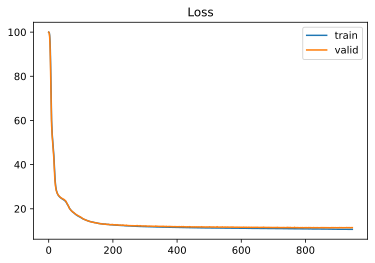

In [305]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='valid')
plt.legend()
plt.show();


In [314]:
model.load_weights('MLP_storage/best_model.hdf5')
#model.save('MLP_storage/nn_3.hdf5')
test_predict_nn1 = model.predict(valid_X)[:,0]
print(f"TEST mape: {(mape(valid_y, test_predict_nn1))*100:0.2f}%")

TEST mape: 11.46%


In [328]:
test_data = pd.concat([data.query("sample=='test'")['sell_id'], test], axis=1)
test_data.price = (model.predict(test_X)[:,0]//1000)*1000
test_data[['sell_id', 'price']].to_csv('mlp_submission.csv', index=False)

MAPE 12.00 on public leaderboard

In [329]:
previous_preds = pd.read_csv('lgbm_bland_submission.csv')
test_data.price = (((test_data.price+previous_preds.price)/2)//1000)*1000
test_data[['sell_id', 'price']].to_csv('mlp_bland_submission.csv', index=False)

MAPE 11.26 on public leaderboard

<a id='5'></a>  
### NLP + DL

In [164]:
#Сколько всего уникальных слов?
s = set()
for word in tqdm.tqdm(' '.join(list(set(data.text_feature.values.flatten().tolist()))).split()):
    s.add(word)
print("Общий размер словаря: {} уникальных слов".format(len(s)))

100%|██████████| 608260/608260 [00:00<00:00, 2125039.96it/s]

Общий размер словаря: 18152 уникальных слов


In [105]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 256

text_train = data.text_feature.iloc[train.index]
text_test = data.text_feature.iloc[valid.index]
text_sub = data.text_feature.iloc[test.index]

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.text_feature)


text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_valid_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

In [106]:
#Восстанавливаем состояние рандома
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


#NLP-LSTM part

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

#MLP part
model_mlp = Sequential()
model_mlp.add(L.Dense(64, input_dim=train_X.shape[1], activation="elu"))
model_mlp.add(L.Dense(64, activation="selu"))

#Combine inputs
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="elu")(combinedInput)
head = L.Dense(1, activation='linear')(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)


optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
checkpoint = ModelCheckpoint('MLP_storage/nlp_best_model.hdf5' , monitor=['val_MAPE'], verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, mode='min', verbose=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=50, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]
### Fit
history = model.fit([text_train_sequences, train_X], train_y,
                    batch_size=256, # изменение batch_size в большую и меньшую сторону также не дает улучшения
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_valid_sequences, valid_X], valid_y),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/500
21/21 [==============================] - 9s 306ms/step - loss: 99.9683 - MAPE: 99.9683 - val_loss: 99.8179 - val_MAPE: 99.8179 - lr: 0.0100
Epoch 2/500
21/21 [==============================] - 5s 264ms/step - loss: 98.7187 - MAPE: 98.7187 - val_loss: 95.9723 - val_MAPE: 95.9723 - lr: 0.0100
Epoch 3/500
21/21 [==============================] - 5s 244ms/step - loss: 87.4871 - MAPE: 87.4871 - val_loss: 71.0533 - val_MAPE: 71.0533 - lr: 0.0100
Epoch 4/500
21/21 [==============================] - 6s 265ms/step - loss: 59.5736 - MAPE: 59.5736 - val_loss: 54.9058 - val_MAPE: 54.9058 - lr: 0.0100
Epoch 5/500
21/21 [==============================] - 6s 275ms/step - loss: 51.3736 - MAPE: 51.3736 - val_loss: 49.0550 - val_MAPE: 49.0550 - lr: 0.0100
Epoch 6/500
21/21 [==============================] - 6s 277ms/step - loss: 46.9662 - MAPE: 46.9662 - val_loss: 45.1535 - val_MAPE: 45.1535 - lr: 0.0100
Epoch 7/500
21/21 [==============================] - 6s 275ms/step - loss: 42.3927 - MAP

In [107]:
#model.load_weights('MLP_storage/nlp_best_modell.hdf5')
#model.save('MLP_storage/nn_3.hdf5')
test_predict_nn1 = model.predict([text_valid_sequences, valid_X])[:,0]
print(f"TEST mape: {(mape(valid_y, test_predict_nn1))*100:0.2f}%")

TEST mape: 11.28%


In [108]:
#Submit
test_data = pd.concat([data.query("sample=='test'")['sell_id'], test], axis=1)
test_data.price = (model.predict([text_test_sequences, test_X])[:,0]//1000)*1000
previous_preds = pd.read_csv('lgbm_bland_submission.csv')
test_data.price = (((test_data.price+previous_preds.price)/2)//1000)*1000
test_data[['sell_id', 'price']].to_csv('nlp_mlp_bland_submission.csv', index=False)

MAPE 11.24 on public leaderboard

In [67]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/sbert_large_nlu_ru', model_max_length=512)
sbert_model = AutoModel.from_pretrained('sberbank-ai/sbert_large_nlu_ru')

device = "cuda:0"

sbert_model  = sbert_model.to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

 

def get_embeddings(sentences, model, device):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

     # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

     # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings


def iterate_minibatches(x, batch_size=128):
    N = len(x)
    left = 0
    right = batch_size
    while right < N:
        yield x[left:right]
        left += batch_size
        right += batch_size
    yield x[left:]


def df_to_emb(train_data):
    all_res = []
    for i in tqdm.tqdm(iterate_minibatches(list(train_data['description'].values), batch_size=16)):
        emb = get_embeddings(i, sbert_model, device).cpu().data.numpy()
        all_res.append(emb)
    return pd.DataFrame(np.vstack(all_res))

In [78]:
#Get embeddings:
train_emb = df_to_emb(train)
valid_emb = df_to_emb(valid)
test_emb = df_to_emb(test)

#Save getting embeddings:
train_emb.to_csv('train_emb.csv', index=False)
valid_emb.to_csv('valid_emb.csv', index=False)
test_emb.to_csv('test_emb.csv', index=False)

In [67]:
#Load embeddings:
train_emb = pd.read_csv('train_emb.csv')
valid_emb = pd.read_csv('valid_emb.csv')
test_emb = pd.read_csv('test_emb.csv')

In [68]:
#Восстанавливаем состояние рандома
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


#Sbert
model_sbert = Sequential()
model_sbert.add(L.Dense(32, input_dim=1024, activation="elu"))

#MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(64, input_dim=train_X.shape[1], activation="elu"))
model_mlp.add(L.Dense(64, activation="selu"))

#Combine inputs
combinedInput = L.concatenate([model_sbert.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="elu")(combinedInput)
head = L.Dense(1, activation='linear')(head)

model = Model(inputs=[model_sbert.input, model_mlp.input], outputs=head)


optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
checkpoint = ModelCheckpoint('MLP_storage/sbert_best_model_sbert_16.hdf5' , monitor='val_MAPE', mode='min', save_best_only=True,)
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, mode='min', restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=50, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]
### Fit
history = model.fit([train_emb.values, train_X], train_y,
                    batch_size=256, # изменение batch_size в большую и меньшую сторону также не дает улучшения
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([valid_emb.values, valid_X], valid_y),
                    callbacks=callbacks_list,
                    verbose=1)

In [69]:
model.load_weights('MLP_storage/sbert_best_model.hdf5')
#model.save('MLP_storage/nn_3.hdf5')
test_predict_nn1 = model.predict([valid_emb.values, valid_X])[:,0]
print(f"TEST mape: {(mape(valid_y, test_predict_nn1))*100:0.2f}%")

TEST mape: 11.13%


In [91]:
#Submit
test_data = pd.concat([data.query("sample=='test'")['sell_id'], test], axis=1)
test_data.price = (model.predict([test_emb, test_X])[:,0]//1000)*1000
previous_preds = pd.read_csv('lgbm_bland_submission.csv')
test_data.price = (((test_data.price+previous_preds.price)/2)//1000)*1000
test_data[['sell_id', 'price']].to_csv('sbert_mlp_bland_submission.csv', index=False)

MAPE 11.10 on public leaderboard

<a id='6'></a>  
### Добавляем CV

Если мы хотим использовать предобученную сеть для обогащения модели полезным сигналом, полученным на основе анализа картинок, то лучше заранее прогннать картинки через эту сеть, получив эмбеддинги, которые затем использовать в главной сети. Если мы понимаем, что веса из Transfer Learning не обеспечивают необходимого качества, то можно попробовать дообучить сеть (здесь уже понадобятся аугментации).

In [145]:
DATA_DIR = 'data_storage/Batmobile/'

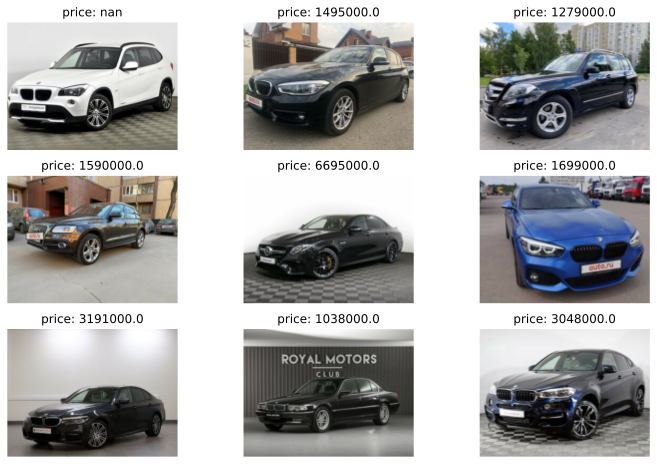

In [79]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = data.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = (random_image['price'].values//1000)*1000

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [80]:
size = (240, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(train.index)
images_valid = get_image_array(valid.index)
images_test = get_image_array(test.index)

images shape (5345, 240, 240, 3) dtype uint8
images shape (1337, 240, 240, 3) dtype uint8
images shape (1671, 240, 240, 3) dtype uint8


In [83]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, train_y))
valid_dataset = tf.data.Dataset.from_tensor_slices((images_valid, valid_y))
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, np.zeros(len(test_X))))

In [84]:
#Загружаем сеть:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

#Инициализируем модель:
efficientnet_model  = Sequential()
efficientnet_model.add(efficientnet)
efficientnet_model.add(L.GlobalAveragePooling2D(),)

In [86]:
train_image_emb = efficientnet_model.predict(train_dataset.batch(8))
valid_image_emb = efficientnet_model.predict(valid_dataset.batch(8))
test_image_emb = efficientnet_model.predict(test_dataset.batch(8))

In [90]:
#Восстанавливаем состояние рандома
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Sbert
model_sbert = Sequential()
model_sbert.add(L.Dense(32, input_dim=1024, activation="selu"))

#MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(64, input_dim=train_X.shape[1], activation="elu"))
model_mlp.add(L.Dense(64, activation="selu"))

#CV model
cv_model = Sequential()
cv_model.add(L.Dense(32, input_dim=2048, activation="elu"))


#Combine inputs
combinedInput = L.concatenate([cv_model.output, model_mlp.output, model_sbert.output])
# being our regression head
head = L.Dense(64, activation="elu")(combinedInput)
head = L.Dense(1, activation='linear')(head)

model = Model(inputs=[cv_model.input, model_mlp.input, model_sbert.input], outputs=head)


optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
checkpoint = ModelCheckpoint('MLP_storage/cv_nlp_mlp.hdf5' , monitor='val_MAPE', mode='min', save_best_only=True,)
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, mode='min', restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]
### Fit
history = model.fit([train_image_emb, train_X, train_emb], train_y,
                    epochs=500,
                    batch_size=256,
                    validation_data=([valid_image_emb, valid_X, valid_emb], valid_y),
                    callbacks=callbacks_list
                   )

Epoch 1/500
21/21 [==============================] - 3s 97ms/step - loss: 99.8762 - MAPE: 99.8762 - val_loss: 99.4099 - val_MAPE: 99.4099 - lr: 0.0100
Epoch 2/500
21/21 [==============================] - 1s 25ms/step - loss: 97.1418 - MAPE: 97.1418 - val_loss: 92.1887 - val_MAPE: 92.1887 - lr: 0.0100
Epoch 3/500
21/21 [==============================] - 0s 23ms/step - loss: 79.6691 - MAPE: 79.6691 - val_loss: 60.2688 - val_MAPE: 60.2688 - lr: 0.0100
Epoch 4/500
21/21 [==============================] - 0s 19ms/step - loss: 54.0170 - MAPE: 54.0170 - val_loss: 52.3125 - val_MAPE: 52.3125 - lr: 0.0100
Epoch 5/500
21/21 [==============================] - 0s 17ms/step - loss: 49.5107 - MAPE: 49.5107 - val_loss: 48.1847 - val_MAPE: 48.1847 - lr: 0.0100
Epoch 6/500
21/21 [==============================] - 0s 16ms/step - loss: 46.8533 - MAPE: 46.8533 - val_loss: 45.5657 - val_MAPE: 45.5657 - lr: 0.0100
Epoch 7/500
21/21 [==============================] - 0s 16ms/step - loss: 43.0403 - MAPE: 43.0

In [91]:
model.load_weights('MLP_storage/cv_nlp_mlp.hdf5')
#model.save('MLP_storage/nn_3.hdf5')
test_predict_nn1 = model.predict([valid_image_emb, valid_X, valid_emb])[:,0]
print(f"TEST mape: {(mape(valid_y, test_predict_nn1))*100:0.2f}%")

TEST mape: 11.68%


In [92]:
#Submit
test_data = pd.concat([data.query("sample=='test'")['sell_id'], test], axis=1)
test_data.price = (model.predict([test_image_emb, test_X, test_emb])[:,0]//1000)*1000
previous_preds = pd.read_csv('lgbm_bland_submission.csv')
test_data.price = (((test_data.price+previous_preds.price)/2)//1000)*1000
test_data[['sell_id', 'price']].to_csv('sbert_mlp_cv_bland_submission.csv', index=False)

MAPE 11.47 on public leaderboard

#### Вариант 2 - Дообучить модель

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

# Беру аугментацию из проекта 7

augmentation = albumentations.Compose([
    albumentations.ShiftScaleRotate(
        p=0.8, #apply these to 80% of the images
        shift_limit=0.1, #translate by (-0.1%, 0.1%)
        scale_limit=0.1, #zoom by (-0.1%, 0.1%)
        rotate_limit=30, #rotate by (-30, 30)
        border_mode=cv2.BORDER_CONSTANT, value = [0,0,0], #fill emptyness with (0,0,0)
        ),
    albumentations.Blur(blur_limit=1, p=0.2),
    albumentations.ElasticTransform(alpha=0.1, sigma=5, alpha_affine=2,
                                     border_mode=cv2.BORDER_CONSTANT, value = [0,0,0], #fill emptyness with (0,0,0)
                                    ),
    albumentations.ToFloat(max_value=255),
])

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tf_process_train_dataset_element(image, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return image, price


train_dataset = tf.data.Dataset.from_tensor_slices((images_train, train_y)).map(tf_process_train_dataset_element)
valid_dataset = tf.data.Dataset.from_tensor_slices((images_valid, valid_y))
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, np.zeros(len(test_X))))

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
valid_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();

In [ ]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
efficientnet.trainable=True

efficientnet_model  = Sequential()
efficientnet_model.add(efficientnet)
efficientnet_model.add(L.GlobalAveragePooling2D(),)
efficientnet_model.add(L.Dense(32, input_dim=2048, activation="linear"))

optimizer = tf.keras.optimizers.Adam(0.001)
efficientnet_model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])
checkpoint=ModelCheckpoint('MLP_storage/ef_net.hdf5' , monitor='val_MAPE', mode='min', save_best_only=True,)
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, mode='min', restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

history = efficientnet_model.fit(train_dataset.batch(16),
                    epochs=100,
                    validation_data=valid_dataset.batch(16),
                    callbacks=callbacks_list
                   )

| Description of submit | Selected features | Tuned | MAPE on leaderboard| 
| :- | :-: | :-: | :-: |
| Baseline | + | - | 18.76 |
| Catboost | - | - | 13.25 |
| Catboost+ExtraTrees | - | - | 12.60 |
| LAMA | - | + | 12.29 |
| Catboost+AdaBoost+LAMA | + | - | 12.13 |
| MLP | + | + | 12.00 |
| LightGBM | - | - | 11.91 |
| LightGBM | + | - | 11.94 |
| LightGBM | - | + | 11.79 |
| LGBMTune+(LAMA+Ada+CB) | -+ | +- | 11.71 |
| MLP+SBERT+CV+(LAMA+Ada+CB) | +++ | ++- | 11.47 |
| MLP+(LAMA+Ada+CB) | ++ | +- | 11.26 |
| MLP+NLP(LSTM)+(LAMA+Ada+CB) | +++ | ++- | 11.24 |
| MLP+NLP(SBERT)(LAMA+Ada+CB) | +++ | ++- | 11.10 |

<a id='7'></a>  
### Анализ лучших результатов

In [101]:
# Посмотрим как распределены ошибки нашего лучшего сабмита
bland = (lama_preds+ada_preds+cb_preds)/3
lgbm_bland = (lgbm_preds+bland)/2
final_predict = ((test_predict_nn1+lgbm_bland)/2)//1000*1000

In [104]:
print(f"TEST mape: {mape(np.exp(valid.price), final_predict)*100:0.2f}%")

TEST mape: 10.44%


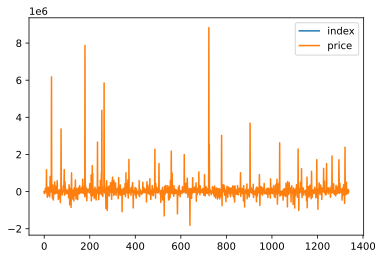

In [123]:
(np.exp(valid.price)-final_predict).reset_index().plot();

In [143]:
#Посмотрим на объявления с самой большой ошибкой:
valid['preds'] = final_predict
valid.loc[abs(valid.price-valid.preds).sort_values(ascending=False)[:9].index].drop(['text_feature', 'description', 'name', 'vehicleconfiguration'], axis=1)

,bodytype,brand,color,enginedisplacement,enginepower,fueltype,mileage,model_info,numberofdoors,price,sell_id,vehicletransmission,owners,ownership,tech_passport,transmission,auto_age,is_premium_package,is_drive_package,miles_per_year,preds
1370,минивэн,MERCEDES,чёрный,2.1,190,дизель,24,VITO,Четыре,15000000.0,1098077334,автоматическая,1,7.0,Оригинал,полный,2,0,0,12,6170000.0
4331,внедорожник,MERCEDES,чёрный,4.0,422,бензин,20000,G_KLASSE,Четыре,15000000.0,1098888624,автоматическая,1,30.0,Оригинал,полный,5,0,0,4000,7129000.0
503,минивэн,MERCEDES,чёрный,2.0,239,дизель,1,V_KLASSE,Четыре,14800000.0,1099907644,автоматическая,1,12.0,Оригинал,полный,1,0,0,1,8623000.0
3121,купе,MERCEDES,серый,6.2,571,бензин,17600,SLS_AMG,Две,14999000.0,1099217106,роботизированная,1,132.0,Оригинал,задний,11,1,0,1600,9148000.0
4461,купе,BMW,оранжевый,3.0,272,бензин,50,3ER,Две,5500000.0,1097997232,механическая,1,180.0,Оригинал,задний,15,0,0,3,1121000.0
2596,внедорожник,BMW,коричневый,4.4,625,бензин,20,X6_M,Четыре,12900000.0,1100209540,автоматическая,1,12.0,Оригинал,полный,1,1,0,20,9219000.0
2917,внедорожник,MERCEDES,чёрный,4.0,585,бензин,15000,G_KLASSE_AMG,Четыре,14999999.0,1098323650,автоматическая,1,24.0,Оригинал,полный,2,1,0,7500,11627000.0
2155,внедорожник,BMW,синий,4.4,625,бензин,28,X6_M,Четыре,12149699.0,1100189964,автоматическая,1,12.0,Оригинал,полный,1,1,0,28,9126000.0
5820,седан,MERCEDES,чёрный,5.5,517,бензин,40000,S_KLASSE,Четыре,4950000.0,1094986996,автоматическая,1,116.0,Оригинал,задний,11,0,0,3636,2285000.0


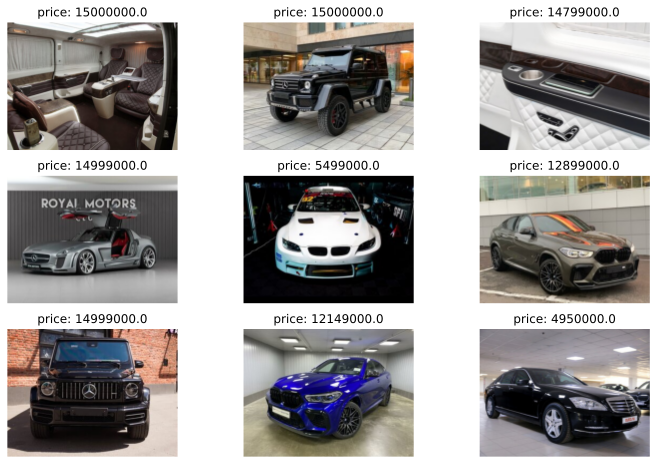

In [146]:
#Посмотрим как выглядят эти авто:
plt.figure(figsize = (12,8))

random_image = valid.loc[abs(valid.price-valid.preds).sort_values(ascending=False)[:9].index]
random_image_paths = random_image['sell_id'].values
random_image_cat = (random_image['price'].values//1000)*1000

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [159]:
#Посмотрим на их описания:
texts =valid.loc[abs(valid.price-valid.preds).sort_values(ascending=False)[:9].index, ['description']]
for index, row in texts.iterrows():
    print(row.values[0])
    print('----'*20)


Люксовый мобильный кабинет с полным мультимедийным набором опций и огромным количеством дизайнерских штучек. Есть действительно всё необходимое для полноценной работы и отдыха в автомобиле.
--------------------------------------------------------------------------------
БЕЗ ТОРГА!
Автомобиль в идеальном состоянии, полностью затянут в защитную пленку, ТО делаю каждый год в МБ РУС на Ленинградке, всю официальную историю без труда подниму. Установлено много оригинального Брабуса. Подробнее расскажу по телефону. Перекупов большая просьба не беспокоить , не спешу
Бьеться два владельца, тк перевешивали номера. Машина в одних руках
--------------------------------------------------------------------------------
Безопасность: 17. Салон: 13. Мультимедиа: 10. Комфорт: 14. Защита от угона: 2. Обзор: 4. 
--------------------------------------------------------------------------------
MERCEDES-BENZ SLS AMG FAB DESIGN!

Дополнительно на автомобиль установлен оригинальный аэродинамический пакет FAB D

### Выводы  

Модель ошибается в большей степени занижая цену люксовых и эксклюзивных автомобилей. Видится, что исправить эту проблему можно дообучением языковой модели и модели компьютерного зрения на доступных данных. Но для этого требуется достаточно много ресурсов.